In [ ]:
# default_exp quantification

# Quantification

> Functions related to quantification

In [ ]:
#hide
from nbdev.showdoc import *

## Label-free quantification

Algorithms related to label-free quantifications are motivated by the [MaxLFQ paper](https://doi.org/10.1074/mcp.m113.031591). The main goal is to derive relative protein intensities that can be used for downstream analyses. In a first step, constant normalization coefficients are derived for each run. In a second step, pseudointensities are derived for each protein, such that differing conditions can be compared.

## Delayed Normalization

Delayed normalization describes the process of normalizing the differences that occur from prefractionation as well as from sample handling. For each sample, a constant scaling factor is derived by minimizing the term
$$H(\vec{N}) = \sum_{P \in peptides} \sum_{A,B \in sample pairs} |\frac{I(N_A, P, A)}{I(N_B, P, B)}|, $$
with peptide intensities $I$, which are determined by the peptide $P$ the sample $A$ or $B$ and the normalization factors $N_A$, $N_B$. In principle H(N) quantifies the variation of peptides over the samples. Minimizing this variation gives appropriate scaling factors under the assumption that most peptides do not change between the samples. Peptide intensities for fractionated samples are described as the sum of the intensities over the fractions, with fraction-specific normalization factors. Therefore, calculation of the summed intensities is *delayed* until the normalization is finished.

### In Silico Test data

To test the delayed normalization approach we create an in silico test dataset with a known ground truth. We therefore know, which systematic changes are between the samples and we employ different solvers to recover the normalization parameters. 

In [ ]:
#export
import random
import numpy as np
import logging

def gaussian(mu: float, sigma: float, grid : np.ndarray) -> np.ndarray:
    """Calculates normally distributed probability densities along an input array.

    Args:
        mu (float): mean of ND.
        sigma (float): standard deviation of ND.
        grid (np.ndarray): input array np.int[:]. For each element of the array, the  probability density is calculated.

    Returns:
        np.ndarray: probability density array, np.float[:].
    """
    norm = 0.3989422804014327 / sigma
    return norm * np.exp(-0.5 * ((grid - mu) / sigma) ** 2)

In [ ]:
#hide
def test_gaussian():
    
    assert np.allclose(gaussian(10, 3, np.arange(5)), np.array([0.00051409, 0.00147728, 0.00379866, 0.00874063, 0.01799699]))
    assert np.allclose(gaussian(1, 3, np.arange(6)), np.array([0.12579441, 0.13298076, 0.12579441, 0.10648267, 0.08065691, 0.05467002]))

test_gaussian() 

In [ ]:
#export
def return_elution_profile(timepoint: float, sigma : float, n_runs : int) -> np.ndarray:
    """Simulates a gaussian elution profile.

    Args:
        timepoint (float): coordinate of the peak apex.
        sigma (float): standard deviation of the gaussian.
        n_runs (int): number of points along which the density is calculated.

    Returns:
        np.ndarray: probability density array, np.float[:].
    """
    return gaussian(timepoint, sigma, np.arange(0, n_runs))

In [ ]:
#hide
def test_return_elution_profile():
    assert np.allclose(return_elution_profile(10, 2, 6), np.array([7.43359757e-07, 7.99187055e-06, 6.69151129e-05, 4.36341348e-04,
           2.21592421e-03, 8.76415025e-03]))

    assert np.allclose(return_elution_profile(1, 5, 3), np.array([0.07820854, 0.07978846, 0.07820854]))

test_return_elution_profile()

In [ ]:
#export
def simulate_sample_profiles(n_peptides: int, n_runs: int, n_samples: int, threshold:float=0.2, use_noise:bool=True) -> [np.ndarray, np.ndarray]:
    """Generates random profiles to serve as test_data.

    Args:
        n_peptides (int): number of peptides to be simulated.
        n_runs (int): number of runs to be simulated.
        n_samples (int): number of samples to be simulated.
        threshold (float, optional): threshold below which a simulated intensity will be diregarded. Defaults to 0.2.
        use_noise (bool, optional): add simulated noise to the profile values. Defaults to True.

    Returns:
        Tuple[np.ndarray, np.ndarray]: profiles: np.float[:,:,:] array containing the simulated profiles, true_normalization: np.float[:,:,:] array containing the ground truth.
    """
    np.random.seed(42)
    abundances = np.random.rand(n_peptides)*10e7

    true_normalization = np.random.normal(loc=1, scale=0.1, size=(n_runs, n_samples))
    true_normalization[true_normalization<0] = 0
    true_normalization = true_normalization/np.max(true_normalization)
    maxvals = np.max(true_normalization, axis=1)
    elution_timepoints = random.choices(list(range(n_runs)), k=n_peptides)

    profiles = np.empty((n_runs, n_samples, n_peptides))
    profiles[:] = np.nan

    for i in range(n_peptides):

        elution_timepoint = elution_timepoints[i]
        abundance = abundances[i]

        profile = return_elution_profile(elution_timepoint, 1, n_runs)
        profile = profile/np.max(profile)
        profile = profile * abundance
        elution_profiles = np.tile(profile, (n_samples, 1)).T

        # Add Gaussian Noise
        if use_noise:
            noise = np.random.normal(1, 0.2, elution_profiles.shape)
            noisy_profile = noise * elution_profiles
        else:
            noisy_profile = elution_profiles

        normalized_profile = noisy_profile * true_normalization

        normalized_profile[normalized_profile < threshold] = 0
        normalized_profile[normalized_profile == 0] = np.nan


        profiles[:,:,i] = normalized_profile

    return profiles, true_normalization

In [ ]:
#hide
def test_simulate_sample_profiles():
    #The function to be tested is a random generator so we only test the output format here
    
    n_peptides = 2
    n_runs = 5
    n_samples = 10
    
    profiles, true_normalization = simulate_sample_profiles(n_peptides, n_runs, n_samples)
    
    assert profiles.shape == (n_runs, n_samples, n_peptides)
    assert true_normalization.shape == (n_runs, n_samples)
    
    assert np.all(profiles > 0)
    assert np.all(true_normalization > 0)
    
test_simulate_sample_profiles()

## Delayed Normalization

In [ ]:
#export
from numba import njit, prange

@njit
def get_peptide_error(profile: np.ndarray, normalization: np.ndarray) -> float:
    """Distance function for least squares optimization. Calculates the peptide ratios between samples. Smaller ratios mean better normalization.

    Args:
        profile (np.ndarray): peptide intensity values.
        normalization (np.ndarray): per sample normalization factors.

    Returns:
        float: summed squared error.
    """
    pep_ints = np.zeros(profile.shape[1])

    normalized_profile = profile*normalization

    for i in range(len(pep_ints)):
        pep_ints[i] = np.nansum(normalized_profile[:,i])

    pep_ints = pep_ints[pep_ints>0]

    # Loop through all combinations
    n = len(pep_ints)

    error = 0
    for i in range(n):
        for j in range(i+1,n):
            error += np.abs(np.log(pep_ints[i]/pep_ints[j]))**2

    return error

In [ ]:
#hide
def test_get_peptide_error():
    profile = np.ones((10, 10))

    normalization = np.ones((10))
    assert get_peptide_error(profile, normalization) == 0

    normalization = np.arange((10))
    assert np.allclose(get_peptide_error(profile, normalization), 37.24832444019646)
    
#test_get_peptide_error() #TODO: this test seems to break the CI

In [ ]:
#export
def get_total_error(normalization: np.ndarray, profiles: np.ndarray) -> float:
    """Computes the summed peptide errors over the whole dataset.

    Args:
        normalization (np.ndarray): per sample normalization factors.
        profiles (np.ndarray): peptide intensity profiles over the dataset.

    Returns:
        float: summed peptide error.
    """
    normalization = normalization.reshape(profiles.shape[:2])

    total_error = 0

    for index in range(profiles.shape[2]):
        total_error += get_peptide_error(profiles[:,:, index], normalization)

    return total_error

In [ ]:
#hide

def test_get_total_error():
    profiles = np.ones((10, 10, 4))

    normalization = np.ones((10, 10))
    assert get_total_error(normalization, profiles) == 0

    normalization = np.array([np.arange(10) for i in range(10)])
    assert np.allclose(get_total_error(normalization, profiles), 4*37.24832444019646)

#test_get_total_error() #TODO: this test seems to break the CI

## Benchmarking different optimiziers
The normalization step is in principle a quadratic minimization of the normalization factors. Such minimization problems can be solved in various ways and a variety of approaches are realized in python community packages. We compare different solvers using our benchmarking set and uncover substantial differences in precision and runtime. We observe that the *Sequential Least Squares Quadratic Programming* (SLSQP) approach is a robust solution in our benchmarking, which gives substantial speed improvements. 

In [ ]:
from scipy.optimize import minimize
from time import time
from scipy.optimize import least_squares
import pandas as pd
import warnings

n_peptides = 100
n_runs = 10
n_samples = 3

profiles, true_normalization = simulate_sample_profiles(n_peptides, n_runs, n_samples)

methods = ['L-BFGS-B', 'TNC', 'SLSQP','trf']

results = []

for method in methods:
    
    start = time()
    
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=RuntimeWarning)
    
        if method in ['trf']:
            x0 = np.ones(profiles.shape[0] * profiles.shape[1])
            bounds = (x0*0.1, x0)
            res = least_squares(get_total_error, args = [profiles], bounds = bounds, x0 = x0*0.5, verbose=0, method = method)

        else:
            x0 = np.ones(profiles.shape[0] * profiles.shape[1])
            bounds = [(0.1, 1) for _ in x0]
            res = minimize(get_total_error, args = profiles , x0 = x0*0.5, bounds=bounds, method=method)

    solution = res.x/np.max(res.x)
    solution = solution.reshape(profiles.shape[:2])
    
    end = time()
    
    time_elapsed_min = (end-start)/60

    optimality = get_total_error(solution, profiles) /get_total_error(x0, profiles)
    optimality_ = get_total_error(solution, profiles) / get_total_error(true_normalization, profiles)
    
    results.append((method, time_elapsed_min, optimality, optimality_))
    
pd.DataFrame(results, columns=['Method', 'Time Elapsed (min)','Error / Baseline Error','Error / Ground Truth'])

,Method,Time Elapsed (min),Error / Baseline Error,Error / Ground Truth
0,L-BFGS-B,0.037820,0.733581,0.584801
1,TNC,0.021796,0.763347,0.608530
2,SLSQP,0.004033,0.733581,0.584801
3,trf,0.243582,0.734344,0.585410


In [ ]:
#export
from scipy.optimize import minimize
import pandas as pd
import numpy as np
import warnings

def normalize_experiment_SLSQP(profiles: np.ndarray) -> np.ndarray:
    """Calculates normalization with SLSQP approach.

    Args:
        profiles (np.ndarray): peptide intensities.

    Returns:
        np.ndarray: normalization factors.
    """
    x0 = np.ones(profiles.shape[0] * profiles.shape[1])
    bounds = [(0.1, 1) for _ in x0]
    res = minimize(get_total_error, args = profiles , x0 = x0*0.5, bounds=bounds, method='SLSQP', options={'disp': False} )

    solution = res.x/np.max(res.x)
    solution = solution.reshape(profiles.shape[:2])

    return solution

In [ ]:
#hide
def test_normalize_experiment_SLSQP():
    n_peptides = 15
    n_runs = 5
    n_samples = 20

    profiles, true_normalization = simulate_sample_profiles(n_peptides, n_runs, n_samples)

    x0 = np.ones(profiles.shape[0] * profiles.shape[1])
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=RuntimeWarning)
        solution = normalize_experiment_SLSQP(profiles)
    optimality = get_total_error(solution, profiles) / get_total_error(x0, profiles)

    assert optimality < 1
    
#test_normalize_experiment_SLSQP() #TODO: this test seems to break the CI

In [ ]:
#export
def normalize_experiment_BFGS(profiles: np.ndarray) -> np.ndarray:
    """Calculates normalization with BFGS approach.

    Args:
        profiles (np.ndarray): peptide intensities.

    Returns:
        np.ndarray: normalization factors.
    """
    x0 = np.ones(profiles.shape[0] * profiles.shape[1])
    bounds = [(0.1, 1) for _ in x0]
    res = minimize(get_total_error, args = profiles , x0 = x0*0.5, bounds=bounds, method='L-BFGS-B', options={'disp': False} )

    solution = res.x/np.max(res.x)
    solution = solution.reshape(profiles.shape[:2])

    return solution

In [ ]:
#hide
def test_normalize_experiment_BFGS():
    n_peptides = 15
    n_runs = 5
    n_samples = 20

    profiles, true_normalization = simulate_sample_profiles(n_peptides, n_runs, n_samples)

    x0 = np.ones(profiles.shape[0] * profiles.shape[1])
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=RuntimeWarning)
        solution = normalize_experiment_BFGS(profiles)
    optimality = get_total_error(solution, profiles) / get_total_error(x0, profiles)

    assert optimality < 1
    
#test_normalize_experiment_BFGS() #TODO: this test seems to break the CI

In [ ]:
#export
def delayed_normalization(df: pd.DataFrame, field: str='int_sum', minimum_occurence:bool=None) -> [pd.DataFrame, np.ndarray]:
    """Returns normalization factors for given peptide intensities.
    If the solver does not converge, the unnormalized data will be used.

    Args:
        df (pd.DataFrame): alphapept quantified features table.
        field (str, optional): The column in df containing the quantitative peptide information (i.e. precursor intensities).
        minimum_occurence (bool, optional): minimum number of replicates the peptide must be observed in. Defaults to None.

    Returns:
        [pd.DataFrame, np.ndarray]: pd.DataFrame: alphapept quantified features table extended with the normalized intensities, np.ndarray: normalized intensities
    """
    files = np.sort(df['filename'].unique()).tolist()
    n_files = len(files)

    if 'fraction' not in df.keys():
        df['fraction'] = [1 for x in range(len(df.index))]

    fractions = np.sort(df['fraction'].unique()).tolist()

    n_fractions = len(fractions)

    df_max = df.groupby(['precursor','fraction','filename'])[field].max() #Maximum per fraction

    prec_count = df_max.index.get_level_values('precursor').value_counts()

    if not minimum_occurence:
        minimum_occurence = np.percentile(prec_count[prec_count>1].values, 75) #Take the 25% best datapoints
        logging.info('Setting minimum occurence to {}'.format(minimum_occurence))

    shared_precs = prec_count[prec_count >= minimum_occurence]


    precs = shared_precs.index.tolist()
    n_profiles = len(precs)

    selected_precs = df_max.loc[precs]
    selected_precs = selected_precs.reset_index()

    profiles = np.empty((n_fractions, n_files, n_profiles))
    profiles[:] = np.nan

    #get dictionaries
    fraction_dict = {_:i for i,_ in enumerate(fractions)}
    filename_dict = {_:i for i,_ in enumerate(files)}
    precursor_dict = {_:i for i,_ in enumerate(precs)}

    prec_id = [precursor_dict[_] for _ in selected_precs['precursor']]
    frac_id = [fraction_dict[_] for _ in selected_precs['fraction']]
    file_id = [filename_dict[_] for _ in selected_precs['filename']]

    profiles[frac_id,file_id, prec_id] = selected_precs[field]
    

    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=RuntimeWarning)

        try:
            normalization = normalize_experiment_SLSQP(profiles)
            norm1d = np.ravel(normalization)
            if sum((norm1d!=1))==0:
                raise ValueError("optimization with SLSQP terminated at initial values. Trying BFGS")
        except ValueError: # SLSQP error in scipy https://github.com/scipy/scipy/issues/11403
            logging.info('Normalization with SLSQP failed. Trying BFGS')
            normalization = normalize_experiment_BFGS(profiles)
            norm1d = np.ravel(normalization)
            if sum((norm1d!=1))==0:
                logging.warn('No normalization factors could be determined. Continuing with non-normalized data.')


    #intensity normalization: total intensity to remain unchanged

    df[field+'_dn'] = df[field]*normalization[[fraction_dict[_] for _ in df['fraction']], [filename_dict[_] for _ in df['filename']]]
    df[field+'_dn'] *= df[field].sum()/df[field+'_dn'].sum()

    return df, normalization

In [ ]:
sample_data = {}

sample_data['precursor'] = ['Prec_1'] * 6 + ['Prec_2'] * 6 + ['Prec_3'] * 6
sample_data['fraction'] = [1,1,2]*6
sample_data['filename'] = ['A','A','A', 'B','B','B'] * 3
sample_data['int_sum'] = [0.6, 0.8, 0.6, 1.2, 1.6, 1.2] * 3

test_df = pd.DataFrame(sample_data)
test_df, normalization = delayed_normalization(test_df, field='int_sum', minimum_occurence=0)

display(pd.DataFrame(normalization))
display(test_df.head(6))

,0,1
0,0.957777,0.480980
1,1.000000,0.497222


,precursor,fraction,filename,int_sum,int_sum_dn
0,Prec_1,1,A,0.6,0.887676
1,Prec_1,1,A,0.8,1.183568
2,Prec_1,2,A,0.6,0.926809
3,Prec_1,1,B,1.2,0.891552
4,Prec_1,1,B,1.6,1.188736
5,Prec_1,2,B,1.2,0.921659


In [ ]:
#hide
def test_delayed_normalization():
    sample_data = {}

    sample_data['precursor'] = ['Prec_1'] * 6 + ['Prec_2'] * 6 + ['Prec_3'] * 6
    sample_data['fraction'] = [1,1,2]*6
    sample_data['filename'] = ['A','A','A', 'B','B','B'] * 3
    sample_data['int_sum'] = [0.6, 0.8, 0.6, 1.2, 1.6, 1.2] * 3

    test_df = pd.DataFrame(sample_data)
    test_df, normalization = delayed_normalization(test_df, field='int_sum', minimum_occurence=0)
    
    assert normalization.shape == (2,2)
    
test_delayed_normalization()

## Constructing protein intensity profiles
Protein intensity profiles are constructed for each protein individually. All possible protein fold changes between the samples are derived from the median peptide fold changes. Subsequently, pseudointensities are chosen such that the fold changes between the pseudointensities ideally reconstruct the actually observed fold changes. Similar to the delayed normalization, this is formulated as a quadratic minimization, which we solve with the SLSQP solver.

Codewise, we start with simulating in-silico test data to serve as a ground-truth for assessing solvers for the optimization problem. For the algorithmic optimization, we define the function `get_protein_ratios` that allows to quickly calculate the protein ratios. Next, we define an error function `triangle_error` that we use for the optimization problem. Lastly, we have several wrapper functions to access the functions. 

## In-silico test data

Create a simulated input dataset of peptide intensities.

In [ ]:
#export
import numpy as np
import string
from time import time
import pandas as pd

np.random.seed(42)

def generate_dummy_data(n_sequences: int, n_samples: int, noise:bool=True, remove:bool= True, peptide_ratio:bool= True, abundance:bool=True, signal_level:int=100, noise_divider:int=10, keep:float=0.8) -> [pd.DataFrame, list, np.ndarray]:
    """Simulate an input dataset of peptide intensities.

    Args:
        n_sequences (int): number of peptides to simulate.
        n_samples (int): number of samples to simulate.
        noise (bool, optional): add random signal to distort the simulated intensity levels. Defaults to True.
        remove (bool, optional): remove intensities (i.e. add missing values). Defaults to True.
        peptide_ratio (bool, optional): simulate different peptide intensities. Defaults to True.
        abundance (bool, optional): simulate different abundances for each sample (i.e. systematic shifts). Defaults to True.
        signal_level (int, optional): signal level for simulated intensity. Defaults to 100.
        noise_divider (int, optional): the factor through which the noise is divided (higher factor -> higher signal to noise). Defaults to 10.
        keep (float, optional): aimed-at fraction of non-missing values, applies if 'remove' is set. Defaults to 0.8.

    Returns:
        [pd.DataFrame, list, np.ndarray]: pd.DataFrame: simulated dataset with peptide intensities, list: sample names: np.ndarray: shift factors of each sample
    """
    species = ['P'+str(_) for _ in range(1,n_sequences+1)]
    sample = [string.ascii_uppercase[_%26]+str(_//26) for _ in range(n_samples)]
    
    if peptide_ratio:
        peptide_ratio = np.random.rand(n_sequences)
        peptide_ratio = peptide_ratio/np.sum(peptide_ratio)
    else:
        peptide_ratio = np.ones(n_sequences)

    if abundance:
        abundance_profile = np.random.rand(n_samples,1)
    else:
        abundance_profile = np.ones((n_samples,1))

    original_signal = np.ones((n_samples, n_sequences))

    noise_sim = (np.random.rand(n_samples, n_sequences)-0.5)/noise_divider

    if noise:
        noisy_signal = original_signal+noise_sim
        noisy_signal = noisy_signal*signal_level*peptide_ratio*abundance_profile
    else:
        noisy_signal = original_signal*signal_level*peptide_ratio*abundance_profile

    if remove:
        #Remove points
        keep_probability = keep #keep 60% of the points 
        to_remove = np.random.rand(n_samples, n_sequences)
        to_remove = to_remove>=keep_probability

        dummy_data = noisy_signal.copy()

        dummy_data[to_remove] = 0

    else:
        dummy_data = noisy_signal

            
    dummy_data = pd.DataFrame(dummy_data, index = sample, columns = species).T
    
    ground_truth = abundance_profile.flatten()
    ground_truth = ground_truth/np.max(ground_truth)
        
    return dummy_data, sample, ground_truth

In [ ]:
#hide
def test_generate_dummy_data():
    #The function to be tested is a random-generateor, so we test the output format here.
    n_samples = 10
    n_sequences = 5

    dummy_data, sample, ground_truth = generate_dummy_data(n_samples, n_sequences)

    assert dummy_data.shape == (n_samples, n_sequences)
    assert len(sample) == n_sequences
    assert len(ground_truth) == n_sequences
    
test_generate_dummy_data()

## Determine pair-wise intenisty ratios
The pair-wise protein ratios are determined from the median peptide ratio.

In [ ]:
#export
from numba import njit

@njit
def get_protein_ratios(signal: np.ndarray, column_combinations: list, minimum_ratios:int = 1) -> np.ndarray:
    """Calculates the protein ratios between samples for one protein.

    Args:
        signal (np.ndarray): np.array[:,:] containing peptide intensities for each sample.
        column_combinations (list): list of all index combinations to compare (usually all sample combinations).
        minimum_ratios (int, optional): minimum number of peptide ratios necessary to calculate a protein ratio. Defaults to 1.

    Returns:
        np.ndarray: np.array[:,:] matrix comparing the ratios for all column combinations.
    """
    n_samples = signal.shape[1]
    ratios = np.empty((n_samples, n_samples))
    ratios[:] = np.nan

    for element in column_combinations:
        i = element[0]
        j = element[1]

        ratio = signal[:,j] / signal[:,i]

        non_nan = np.sum(~np.isnan(ratio))

        if non_nan >= minimum_ratios:
            ratio_median = np.nanmedian(ratio)
        else:
            ratio_median = np.nan

        ratios[j,i] = ratio_median

    return ratios

In [ ]:
#hide
from itertools import combinations
from numba.typed import List

def test_get_protein_ratios():
    n_samples = 5
    n_peptides = 2

    signal = np.ones((n_samples, n_peptides))
    column_combinations = List([_ for _ in combinations(range(n_samples), 2)])

    ratios = get_protein_ratios(signal, column_combinations)

    assert ratios[1,0] == 1

    signal[:,1]*=2

    ratios = get_protein_ratios(signal, column_combinations)

    assert ratios[1,0] == 2
    
test_get_protein_ratios() #TODO: this test seems to break the CI

## Error Function
The error function evaluates the difference between the actual observed fold change and the fold change that is derived from the pseudointensities.

In [ ]:
#export
@njit
def triangle_error(normalization: np.ndarray, ratios:np.ndarray) -> float:
    """Calculates the difference between calculated ratios and expected ratios.

    Args:
        normalization (np.ndarray): Used normalization.
        ratios (np.ndarray): Peptide ratios.

    Returns:
        float: summed quadratic difference.
    """
    int_matrix = np.repeat(normalization, len(normalization)).reshape((len(normalization), len(normalization))).transpose()
    x = (np.log(ratios) - np.log(int_matrix.T) + np.log(int_matrix))**2

    return np.nansum(x)

In [ ]:
#hide
def test_triangle_error():
    n_samples = 5
    n_peptides = 4

    signal = np.ones((n_samples, n_peptides))
    column_combinations = List([_ for _ in combinations(range(n_samples), 2)])

    ratios = get_protein_ratios(signal, column_combinations)
    x0 = np.ones(ratios.shape[1])

    assert triangle_error(x0, ratios) == 0

    signal[:,1]*=2
    ratios = get_protein_ratios(signal, column_combinations)
    x0 = np.ones(ratios.shape[1])

    assert np.allclose(triangle_error(x0, ratios), 1.441359041754604)
    
test_triangle_error()

## Solver implementation
As with the delayed normalization we implement multiple solvers from scipy.

In [ ]:
#export
## L-BFGS-B
from scipy.optimize import minimize, least_squares

def solve_profile(ratios: np.ndarray, method: str) -> [np.ndarray, bool]:
    """Calculates protein pseudointensities with a specified solver.

    Args:
        ratios (np.ndarray): np.array[:,:] matrix containing all estimated protein ratios between samples.
        method (str): string specifying which solver to use.

    Raises:
        NotImplementedError: if the solver is not implemented.

    Returns:
        [np.ndarray, bool]: np.ndarray: the protein pseudointensities, bool: wether the solver was successful.
    """
    if method not in ['L-BFGS-B', 'SLSQP', 'Powell', 'trust-constr','trf']:
        raise NotImplementedError(method)
        
    x0 = np.ones(ratios.shape[1])
    bounds = [(min(np.nanmin(ratios), 1/np.nanmax(ratios)), 1) for _ in x0]
    
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=RuntimeWarning)
    
        if method == 'trf':
            bounds = (x0*0+0.01, x0)
            res_wrapped = least_squares(triangle_error, args = [ratios] , x0 = x0, bounds=bounds, verbose=0, method = 'trf')
            solution = res_wrapped.x
        else:
            res_wrapped = minimize(triangle_error, args = ratios , x0 = x0, bounds=bounds, method = method)
            solution = res_wrapped.x
            
    solution = solution/np.max(solution)
    
    return solution, res_wrapped.success

In [ ]:
#hide
def test_solve_profile():
    # The tested function is a wrapper for scipy, so we only test execution here
    n_samples = 5
    n_peptides = 2

    signal = np.ones((n_samples, n_peptides))
    column_combinations = List([_ for _ in combinations(range(n_samples), 2)])

    ratios = get_protein_ratios(signal, column_combinations)

    for method in ['L-BFGS-B', 'SLSQP', 'Powell', 'trust-constr','trf']:
        solve_profile(ratios, method)
        
test_solve_profile()

## Solving single profiles

In [ ]:
#export
from numba.typed import List
from itertools import combinations
import pandas as pd


def protein_profile(files: list, minimum_ratios: int, chunk:tuple) -> (np.ndarray, np.ndarray, str):
    """Function to extract optimal protein ratios for a given input of peptides.
    
    Note for the chunk argument: This construction is needed to call this function from a parallel pool.
    
    Args:
        files (list): A list of files for which the profile shall be extracted.
        minimum_ratios (int): A minimum number of peptide ratios to be considered for optimization.
        chunk: (tuple[pd.DataFrame, str]): A pandas dataframe with the peptide information and a string to identify the protein.

    """
    grouped, protein = chunk

    column_combinations = List()
    [column_combinations.append(_) for _ in combinations(range(len(files)), 2)]
    
    selection = grouped.unstack().T.copy()
    selection = selection.replace(0, np.nan)

    if not selection.shape[1] == len(files):
        selection[[_ for _ in files if _ not in selection.columns]] = np.nan

    selection = selection[files]

    ratios = get_protein_ratios(selection.values, column_combinations, minimum_ratios)
    
    retry = False
    try:
        solution, success = solve_profile(ratios, 'L-BFGS-B')
    except ValueError:
        retry = True

    if retry or not success:
        logging.info('Normalization with L-BFGS-B failed. Trying Powell')
        solution, success = solve_profile(ratios, 'Powell')
        
    pre_lfq = selection.sum().values

    if not success or np.sum(~np.isnan(ratios)) == 0: # or np.sum(solution) == len(pre_lfq):
        profile = np.zeros_like(pre_lfq)
        if np.sum(np.isnan(ratios)) != ratios.size:
            logging.info(f'Solver failed for protein {protein} despite available ratios:\n {ratios}')

    else:
        invalid = ((np.nansum(ratios, axis=1) == 0) & (np.nansum(ratios, axis=0) == 0))
        total_int = pre_lfq.sum() * solution 
        total_int[invalid] = 0
        profile = total_int * pre_lfq.sum() / np.sum(total_int) #Normalize inensity again
        
    
    return profile, pre_lfq, protein  


,precursor,filename,protein_group,int_sum
0,Prec_1,A,X,0.6
1,Prec_1,B,X,0.8
2,Prec_1,C,X,1.0
3,Prec_2,A,X,0.6
4,Prec_2,B,X,1.2
5,Prec_2,C,X,1.4


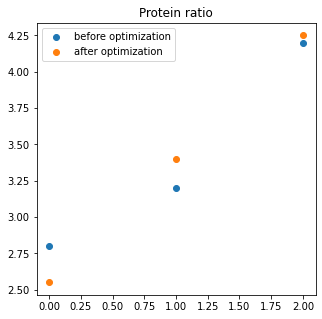

In [ ]:
import matplotlib.pyplot as plt

sample_data = {}

sample_data['precursor'] = ['Prec_1'] * 3 + ['Prec_2'] * 3 + ['Prec_3'] * 3
sample_data['filename'] = ['A','B','C'] * 3
sample_data['protein_group'] = ['X'] * 9
sample_data['int_sum'] = [0.6, 0.8, 1.0, 0.6, 1.2, 1.4, 1.6, 1.2, 1.8]

test_df = pd.DataFrame(sample_data)

display(test_df.head(6))

grouped = test_df.groupby(['protein_group','filename','precursor']).sum().loc['X']
files = ['A','B','C']
minimum_ratios = 1
chunk = (grouped, 'X')

profile, pre_lfq, protein = protein_profile(files, minimum_ratios, chunk)

plt.figure(figsize=(5,5))
plt.title('Protein ratio')
plt.plot(pre_lfq, 'o', label='before optimization')
plt.plot(profile, 'o', label='after optimization')
plt.legend()
plt.show()


In [ ]:
#hide
def test_protein_profile():

    sample_data = {}
    sample_data['precursor'] = ['Prec_1'] * 6 + ['Prec_2'] * 6 + ['Prec_3'] * 6
    sample_data['fraction'] = [1,2,3]*6
    sample_data['filename'] = ['A','A','A', 'B','B','B'] * 3
    sample_data['protein_group'] = ['X'] * 18
    sample_data['int_sum'] = [0.6, 0.8, 0.6, 1.2, 1.6, 1.2] * 3
    test_df = pd.DataFrame(sample_data)

    grouped = test_df.groupby(['protein_group','filename','precursor']).sum().loc['X']
    files = ['A','B']
    minimum_ratios = 1
    chunk = (grouped, 'X')

    profile, pre_lfq, protein = protein_profile(files, minimum_ratios, chunk)
    assert np.allclose(profile.sum(), pre_lfq.sum())

    sample_data = {}
    sample_data['precursor'] = ['Prec_1'] * 2 + ['Prec_2'] * 2 + ['Prec_3'] * 2
    sample_data['filename'] = ['A','B'] * 3
    sample_data['protein_group'] = ['X'] * 6
    sample_data['int_sum'] = [0.6, 0.8, 0.6, 1.2, 1.6, 1.2]

    test_df = pd.DataFrame(sample_data)

    grouped = test_df.groupby(['protein_group','filename','precursor']).sum().loc['X']
    files = ['A','B']
    minimum_ratios = 1
    chunk = (grouped, 'X')

    profile, pre_lfq, protein = protein_profile(files, minimum_ratios, chunk)

    assert np.allclose(profile.sum(), pre_lfq.sum())

test_protein_profile()

## Wrapper functions

To be compatible with interface, we have three wrapper functions:

* protein_profile_parallel: A wrapper that executes protein_profile in parallel
* protein_profile_parallel_ap: A wrapper function to calculate protein ratios based on AlphaPept tabular data
* protein_profile_prallalel_mq: A wrapper function to calculate protein ratios based on MaxQuant tabular data

In [ ]:
#export 

import os
import alphapept.speed
from functools import partial

# This function invokes a parallel pool and has therfore no dedicated test in the notebook
def protein_profile_parallel(df: pd.DataFrame, minimum_ratios: int, field: str, callback=None) -> pd.DataFrame:
    """Derives LFQ intensities from the feature table.

    Args:
        df (pd.DataFrame): Feature table by alphapept.
        minimum_ratios (int): Minimum number of peptide ratios necessary to derive a protein ratio.
        field (str): The field containing the quantitative peptide information (i.e. precursor intensities). 
        callback ([type], optional): Callback function. Defaults to None.

    Returns:
        pd.DataFrame: table containing the LFQ intensities of each protein in each sample.
    """
    unique_proteins = df['protein_group'].unique().tolist()
    
    files = df['filename'].unique().tolist()
    files.sort()
    
    columnes_ext = [_+'_LFQ' for _ in files]
    protein_table = pd.DataFrame(index=unique_proteins, columns=columnes_ext + files)

    grouped = df[[field, 'filename','precursor','protein_group']].groupby(['protein_group','filename','precursor']).sum()

    column_combinations = List()
    [column_combinations.append(_) for _ in combinations(range(len(files)), 2)]
    
    files = df['filename'].unique().tolist()
    files.sort()
    
    results = []
    
    if len(files) > 1:
        logging.info('Preparing protein table for parallel processing.')
        split_df = []
        
        for idx, protein in enumerate(unique_proteins):
            split_df.append((grouped.loc[protein], protein))
            if callback:
                callback((idx+1)/len(unique_proteins)*1/5)
        
        results = []

        logging.info(f'Starting protein extraction for {len(split_df)} proteins.')
        with alphapept.speed.AlphaPool(-1) as p:
            max_ = len(split_df)
            for i, _ in enumerate(p.imap_unordered(partial(protein_profile, files, minimum_ratios), split_df)):
                results.append(_)
                if callback:
                    callback((i+1)/max_*4/5+1/5)

        for result in results:
            profile, pre_lfq, protein = result
            protein_table.loc[protein, [_+'_LFQ' for _ in files]] = profile
            protein_table.loc[protein, files] = pre_lfq

        protein_table[protein_table == 0] = np.nan
        protein_table = protein_table.astype('float')
    else:
        protein_table = df.groupby(['protein_group'])[field].sum().to_frame().reset_index()
        protein_table = protein_table.set_index('protein_group')
        protein_table.index.name = None
        protein_table.columns=[files[0]] 
        
        if callback:
            callback(1)
        
    return protein_table

In [ ]:
#export

# This function invokes a parallel pool and has therfore no dedicated test in the notebook
def protein_profile_parallel_ap(settings: dict, df : pd.DataFrame, callback=None) -> pd.DataFrame:
    """Derives protein LFQ intensities from the alphapept quantified feature table

    Args:
        settings (dict): alphapept settings dictionary.
        df (pd.DataFrame): alphapept feature table.
        callback ([type], optional): [description]. Defaults to None.

    Raises:
        ValueError: raised in case of observed negative intensities.

    Returns:
        pd.DataFrame: table containing the LFQ intensities of each protein in each sample.
    """
    minimum_ratios = settings['quantification']['lfq_ratio_min']
    field = settings['quantification']['mode']
    
    if field+'_dn' in df.columns:
        field_ = field+'_dn'
    else:
        field_ = field

    if df[field_].min() < 0:
        raise ValueError('Negative intensity values present.')
        
    protein_table = protein_profile_parallel(df, minimum_ratios, field_, callback)
    
    return protein_table
    
# This function invokes a parallel pool and has therfore no dedicated test in the notebook
def protein_profile_parallel_mq(evidence_path : str, protein_groups_path: str, callback=None) -> pd.DataFrame:
    """Derives protein LFQ intensities from Maxquant quantified features.

    Args:
        evidence_path (str): path to the Maxquant standard output table evidence.txt.
        protein_groups_path (str): path to the Maxquant standard output table proteinGroups.txt.
        callback ([type], optional): [description]. Defaults to None.

    Raises:
        FileNotFoundError: if Maxquant files cannot be found.

    Returns:
        pd.DataFrame: table containing the LFQ intensities of each protein in each sample.
    """
    logging.info('Loading files')
    
    for file in [evidence_path, protein_groups_path]:
        if not os.path.isfile(file):
            raise FileNotFoundError(f'File {file} not found.')
            
    evd = pd.read_csv(evidence_path, sep='\t') 
    ref = pd.read_csv(protein_groups_path, sep='\t')
            
    experiments = evd['Raw file'].unique().tolist()
    logging.info(f'A total of {len(experiments):,} files.')

    protein_df = []
    
    max_ = len(ref)
    for i in range(max_):
        investigate = ref.iloc[i]
        evd_ids = [int(_) for _ in investigate['Evidence IDs'].split(';')]
        subset = evd.loc[evd_ids].copy()

        subset['protein_group'] =  investigate['Protein IDs']
        subset['filename'] = subset['Raw file']
        subset['precursor']  = ['_'.join(_) for _ in zip(subset['Sequence'].values, subset['Charge'].values.astype('str'))]

        protein_df.append(subset)
        
        if callback:
            callback((i+1)/len(ref))
                     
    logging.info(f'A total of {max_:,} proteins.')

    df = pd.concat(protein_df)
    df, normed = delayed_normalization(df, field ='Intensity')
    protein_table = protein_profile_parallel(df, minimum_ratios=1, field='Intensity', callback=callback)
                     
    return protein_table

In [ ]:
#hide
from nbdev.export import *
notebook2script()

Converted 00_settings.ipynb.
Converted 01_chem.ipynb.
Converted 02_io.ipynb.
Converted 03_fasta.ipynb.
Converted 04_feature_finding.ipynb.
Converted 05_search.ipynb.
Converted 06_score.ipynb.
Converted 07_recalibration.ipynb.
Converted 08_quantification.ipynb.
Converted 09_matching.ipynb.
Converted 10_constants.ipynb.
Converted 11_interface.ipynb.
Converted 12_speed.ipynb.
Converted 13_export.ipynb.
Converted 13_performance.ipynb.
Converted additional_code.ipynb.
Converted contributing.ipynb.
Converted file_formats.ipynb.
Converted index.ipynb.
